##  텍스트 요약(Text Summarization) : Attention 사용

### I - Attention 사용 모델 구현을 위한 데이터 준비하기 : 아마존 리뷰 데이터 'Reviews.csv'

#### 1. 라이브러리 가져오기

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 2.데이터 가져오기

In [ ]:
!gdown 1IQB1AHVeGsKNp67rU5iSytQnJvUHedkJ

Downloading...
From: https://drive.google.com/uc?id=1IQB1AHVeGsKNp67rU5iSytQnJvUHedkJ
To: /content/Reviews.csv
100% 301M/301M [00:01<00:00, 182MB/s]


In [ ]:
#data = pd.read_csv("/content/drive/My Drive/90_AI_Lecture/AI/ai_nlp_main/04_NLP_Ex/Reviews.csv", nrows = 100000)

data = pd.read_csv("Reviews.csv", nrows = 100000) # 56만개중에서 10만개 만 읽어옴
len(data)

100000

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [ ]:
data.sample(10)

,Text,Summary
2672,"The first ingredient in this mix, before the t...","Beware, if you have a corn allergy!!"
51900,I treat my animal's health as if it were my ow...,"My dog is happy, healthy, and I heartily recom..."
46602,I never thought anything could pull me away fr...,It's good!
71826,This shampoo is as wonderful as the conditione...,Smells wonderful and leaves my hair soft and f...
97311,These shields are great for saving wine a few ...,"Great, easy solution"
31833,"I couldn't find it in my local store, thankful...",For my dog...
59538,I haven't used this product yet. But if it wor...,Safer Brand 5162 Caterpillar Killer with B.T. ...
8451,"I am not a huge coconut fan, so I wasn't excit...",Delicious!!
57335,"Often with coffee in general, and especially k...",One of the best flavored K-cups I've tried
41196,Very good licorice. It is like a soft carmel w...,licorice


### 3. 전처리 함수
`preprocess_sentence`라는 함수가 정의되어 텍스트를 정제하고 토큰화함.
   - 소문자로 변환
   - HTML 태그 제거
   - 축약형 확장 (예: "can't"를 "cannot"로)
   - 소유격 종료 제거
   - 영문자가 아닌 문자 제거
   - 선택적으로 불용어 제거

In [ ]:
print(data['Text'].nunique())
print(data['Summary'].nunique())

88426
72348


In [ ]:
# text 열에서 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
len(data)

88426

In [ ]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [ ]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
len(data)

88425

In [ ]:
# 줄임말(축약어)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [ ]:
# 불용어 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'shouldn', "she's", "you've", "didn't", 'all', 'some', 'i', 'that', 'mustn', 'wouldn', 'about', 'is', "you'd", 'as', 'was', 'she', 'for', 'hadn', "needn't", "shouldn't", 'into', 'my', 'who', 'had', 'until', 'against', 'we', 'in', 'where', 'those', 'themselves', 'this', 'am', 're', "wouldn't", "that'll", 'has', 'during', 'the', 'of', 'them', "should've", "wasn't", 'didn', 've', 'its', 'yourselves', 'own', 'other', 'so', 'not', 'while', 'm', "hasn't", 'can', 'after', 'up', 'haven', 'an', 'now', "haven't", "mightn't", 'below', 'a', 'and', 'why', 'through', 's', 'theirs', 'd', 'been', 'further', 'needn', "won't", 'or', "you'll", 'doing', 'but', 'more', "hadn't", 'too', 'couldn', "it's", 'mightn', 'there', 'under', 'wasn', 'what', 'shan', "shan't", 'ours', 'most', 'doesn', 'each', 'very', 'on', 'ain', 'o', 'don', 'whom', 'yours', 'be', 'down', 'just', "aren't", 'yourself', "doesn't", 'me', 'ourselves', 'being', 'having', 'itself', 'weren', 'they', 'only', 'with', 'such', 'abov

In [ ]:
# remove_stopwords = True 는 지우면 됨
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                     # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)         # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 4. 전처리 적용
`preprocess_sentence` 함수가 'Text'와 'Summary' 열에 적용됩니다. 전처리 후 발생한 빈 문자열은 NaN으로 대체되고 Drop함.

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))  # 불용어를 제거하지 않고 괄호로 닫힌 문자열을 제거한다

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [ ]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

<ipython-input-65-a41c768713bd>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

<ipython-input-65-a41c768713bd>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
<ipython-input-65-a41c768713bd>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [ ]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [ ]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [ ]:
data.dropna(axis = 0, inplace = True)
len(data)

88355

Text min : 2
Text max : 1235
Text mean : 38.792428272310566
Summary min : 1
Summary max : 28
Summary mean : 4.010729443721352


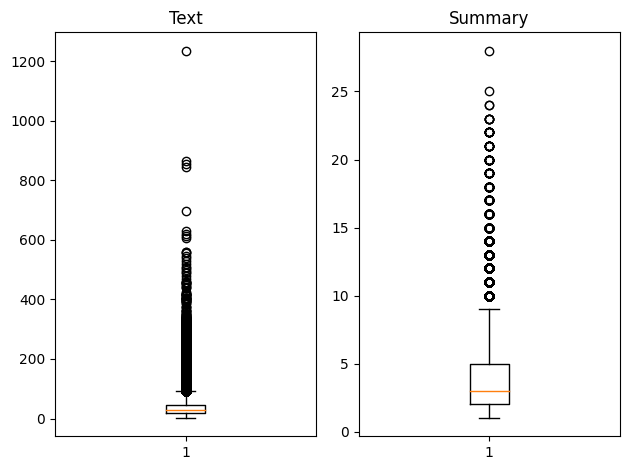

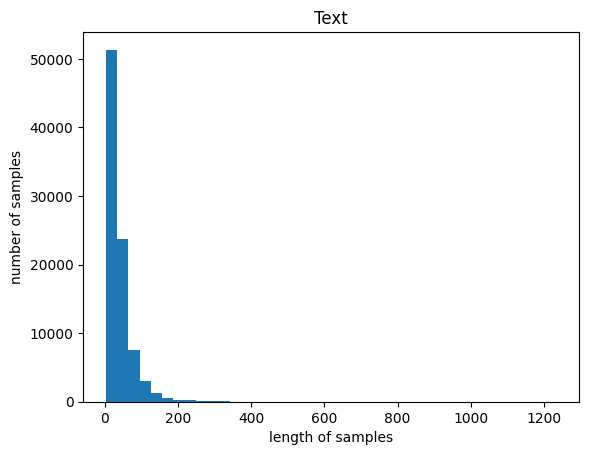

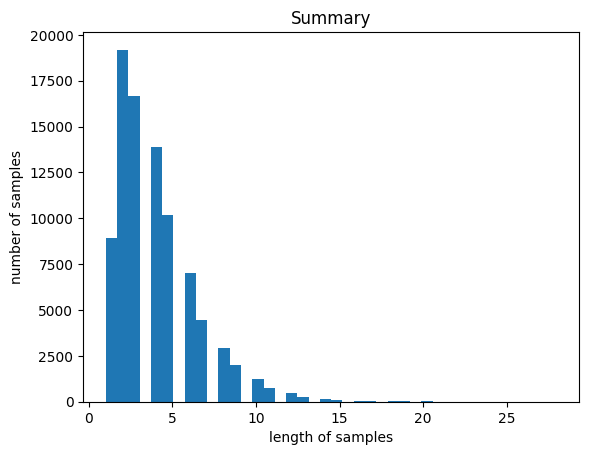

In [ ]:
# 길이 분포 시각화
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('Text min : {}'.format(np.min(text_len)))
print('Text max : {}'.format(np.max(text_len)))
print('Text mean : {}'.format(np.mean(text_len)))
print('Summary min : {}'.format(np.min(summary_len)))
print('Summary max : {}'.format(np.max(summary_len)))
print('Summary mean : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

4-1. 긴 문장 필터링
'Text'에서 50단어보다 긴 문장과 'Summary'에서 8단어보다 긴 문장은 드랍하여 모델의 효율성과 성능 보장.

In [ ]:
text_max_len = 50
summary_max_len = 8

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [ ]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [ ]:
# 최대 길이보다 큰 샘플들은 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]       # Text의 길이가 50이하인 행 추출
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)] # Summary의 길이가 8이하인 행 추출
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [ ]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


#### 4-2. 요약에 시작 및 종료 토큰 추가
- 요약에 시작 및 종료 토큰을 추가하여 모델이 요약의 시작과 끝을 구별할 수 있도록 함
- 시퀀스-투-시퀀스 모델(주어진 입력 시퀀스를 바탕으로 출력 시퀀스를 생성하는 모델)이 텍스트를 요약할 때 시작과 끝을 알 수 있도록 하기 위해서 임. 텍스트 요약과 같은 작업에서 모델이 요약문을 생성하기 시작할 때 어디에서 시작해야 하는지, 그리고 요약문 생성을 멈출 때 어디에서 멈춰야 하는지 알아야 합니다.

- 시작 토큰 (sostoken)
    - 모델에게 요약문 생성을 시작할 시점을 알려줌 : 디코더에게 입력 시퀀스를 바탕으로 첫 번째 단어를 생성하라는 신호로 작용합니다.

- 종료 토큰 (eostoken)
    - 모델에게 요약문 생성을 멈출 시점을 알려줌 - 이 토큰이 생성되면 모델은 더 이상의 단어를 생성하지 않고 요약문 생성을 종료합니다.

In [ ]:
# 시작 토큰과 종료 토큰을 추가
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


In [ ]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

#### 4-3. 데이터 분할
데이터를 훈련 세트와 테스트 세트로 분할합니다.

In [ ]:
# 훈련 데이터와 테스트 데이터를 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


#### 4-4. 토큰화 - Text 데이터
텍스트 데이터가 Keras의 Tokenizer 클래스를 사용하여 토큰화됩니다. 드문 단어(7번 미만으로 나타나는 단어)는 어휘에서 제거됩니다.

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in src_tokenizer.word_counts.items():  # word_counts :단어의 빈도
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('--X_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--X_train--
단어 집합(vocabulary)의 크기 : 31940
등장 빈도가 6번 이하인 희귀 단어의 수: 23707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8233
단어 집합에서 희귀 단어의 비율: 74.22354414527238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3949897589412323


In [ ]:
# Text 토큰화
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(X_train)

X_train = src_tokenizer.texts_to_sequences(X_train)
X_test = src_tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:5])

[[4256, 611, 816, 4477, 528, 1540, 32, 45, 4, 79, 2281, 234, 19, 1157, 2923, 948, 1122, 996, 2, 153, 10, 43], [204, 15, 154, 51, 259, 60, 73, 24, 49, 17, 886, 259, 2, 29, 209, 14, 504, 2081, 420, 13, 86, 64, 22, 2464, 134, 14, 504, 86], [112, 1570, 2, 1771, 185, 39, 505, 112, 283], [296, 105, 496, 834, 69, 103, 334, 5082, 2294, 765, 7, 908, 585, 1489, 351, 5265, 100, 75, 1908, 137, 141, 585, 864, 5083, 89, 830, 564, 1772, 305, 254, 1541, 97, 247, 2, 1600, 2100, 92, 2645], [54, 1247, 806, 5, 497, 479, 46, 236, 1218, 381, 5, 3879, 3880, 172, 479, 46, 1247]]


#### 4-4. 토큰화 - Summary 데이터

In [ ]:
#  요약 데이터 토큰화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('--y_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--y_train--
단어 집합(vocabulary)의 크기 : 10498
등장 빈도가 5번 이하인 희귀 단어의 수: 8126
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2372
단어 집합에서 희귀 단어의 비율: 77.40522004191274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.833194065065198


In [ ]:
tar_vocab = 1000  # or 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train)
y_test = tar_tokenizer.texts_to_sequences(y_test)

In [ ]:
print(y_train[:5])
type(y_train)

[[1, 805, 2], [1, 7, 298, 138, 86, 2], [1, 25, 745, 2], [1, 488, 39, 22, 30, 12, 2], [1, 15, 16, 238, 84, 35, 12, 2]]


list

In [ ]:
# 빈 샘플 제거¶
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [ ]:
print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))
X_test.shape

X_train : 50512
y_train : 50512
X_test : 12609
y_test : 12609


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


(12609,)

### 5. 패딩

In [ ]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')


In [ ]:
X_train[:3]

array([[4256,  611,  816, 4477,  528, 1540,   32,   45,    4,   79, 2281,
         234,   19, 1157, 2923,  948, 1122,  996,    2,  153,   10,   43,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 204,   15,  154,   51,  259,   60,   73,   24,   49,   17,  886,
         259,    2,   29,  209,   14,  504, 2081,  420,   13,   86,   64,
          22, 2464,  134,   14,  504,   86,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 112, 1570,    2, 1771,  185,   39,  505,  112,  283,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

###  II- Seq2eq 와 Attention 사용 모델 구현

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len :50

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.0)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 64)               512000    ['input_3[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 128),            98816     ['embedding_2[0][0]']         
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                            

In [ ]:
# 깃허브에 공개된 attention.py 사용하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 64)               512000    ['input_3[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 128),            98816     ['embedding_2[0][0]']         
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

# 약 9분 소요(GPU)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
198/198 [==============================] - 28s 102ms/step - loss: 3.0136 - val_loss: 2.6314
Epoch 2/50
198/198 [==============================] - 12s 63ms/step - loss: 2.5891 - val_loss: 2.5235
Epoch 3/50
198/198 [==============================] - 11s 55ms/step - loss: 2.5123 - val_loss: 2.4791
Epoch 4/50
198/198 [==============================] - 10s 51ms/step - loss: 2.4685 - val_loss: 2.4391
Epoch 5/50
198/198 [==============================] - 9s 48ms/step - loss: 2.4191 - val_loss: 2.3905
Epoch 6/50
198/198 [==============================] - 10s 50ms/step - loss: 2.3779 - val_loss: 2.3599
Epoch 7/50
198/198 [==============================] - 10s 53ms/step - loss: 2.3434 - val_loss: 2.3337
Epoch 8/50
198/198 [==============================] - 10s 49ms/step - loss: 2.3105 - val_loss: 2.2950
Epoch 9/50
198/198 [==============================] - 10s 49ms/step - loss: 2.2786 - val_loss: 2.2706
Epoch 10/50
198/198 [==============================] - 10s 50ms/step - loss: 2.248

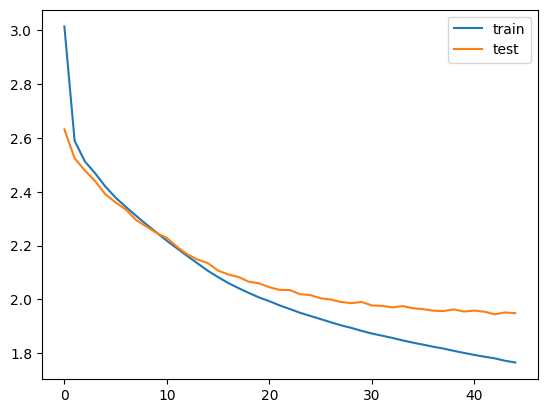

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

###  Test

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 64)            512000    
                                                                 
 lstm_4 (LSTM)               [(None, 50, 128),         98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_5 (LSTM)               [(None, 50, 128),         131584    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_6 (LSTM)               [(None, 50, 128),         1315

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, None, 64)             64000     ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                            

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(X_test[i]))
    print("실제 요약문 :",seq2summary(y_test[i]))
    print("예측 요약문 :",decode_sequence(X_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  dirty martini olive husband loves martini like people jars olives juice read company online actually cheaper order amazon husband fussy martini drinker loves amazing save buying lots jars olives never get used give try disappointed 
실제 요약문 : if you like 
1/1 [==============================] - 0s 21ms/step
예측 요약문 :  great product


원문 :  impressed tuna ok companies efforts ended giving cans away used meal usually like tuna oil thought flavor lacking think tuna canned juices much better wild planet caught wild tuna ounce cans 
실제 요약문 : did not like too much 
1/1 [==============================] - 0s 21ms/step
예측 요약문 :  not as advertised


원문 :  coffee excellent delivered makes count lasts long enough two us month definitely keep coming 
실제 요약문 : good coffee 
1/1 [==============================] - 0s 21ms/step
예측 요약문 :  great coffee


원문 :  buying coffee least years love smooth taste hint hazelnut friends enjoy coming good cup coffee 
실제 요약문 : great coffee 
1/1 [====================

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pd.read_csv("Reviews.csv", nrows = 100000)
data = data[['Text','Summary']]

print(data['Text'].nunique())
print(data['Summary'].nunique())

data.drop_duplicates(subset=['Text'], inplace=True)

data.dropna(axis=0, inplace=True)

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

stop_words = set(stopwords.words('english'))

def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                     # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)         # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

data['Text'] = clean_text
data['Summary'] = clean_summary
data.replace('', np.nan, inplace=True)
data.dropna(axis = 0, inplace = True)

text_max_len = 50
summary_max_len = 8
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]       # Text의 길이가 50이하인 행 추출
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')

Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in src_tokenizer.word_counts.items():  # word_counts :단어의 빈도
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(X_train)


X_train = src_tokenizer.texts_to_sequences(X_train)
X_test = src_tokenizer.texts_to_sequences(X_test)

#  요약 데이터 토큰화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')



88426
72348


<ipython-input-111-0bc81f9bdc78>:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
<ipython-input-111-0bc81f9bdc78>:47: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


ValueError: ignored